# Downloading the Dataset

# About the Data:
The Data is from the famous Titanic ship crash in 1912, it contains information about its passangers, like their age, their names, where they embarked, etc.
The objective here is to predict whether a passenger survived the crash or not, based enterely on the information given.
For that we will use many different supervised learning models as to predict the data as best as possible.
For more information about the dataset, visit its [kaggle page](https://www.kaggle.com/competitions/titanic/data), as it was intended to be used for a data science competition.


In [718]:
import requests
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.svm import LinearSVC
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
from sklearn.preprocessing import label_binarize
from sklearn.linear_model import LogisticRegressionCV
from sklearn.svm import SVC
import numpy as np
from imblearn.over_sampling import RandomOverSampler, SMOTE
import matplotlib.pylab as plt
import seaborn as sns
from sklearn.tree import export_graphviz
from sklearn.tree import plot_tree
import pydotplus
from IPython.display import Image


In [719]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [720]:
def Built_Conf_Matrix(y_test,PredictionsModel,Title):
    conf_matrix = confusion_matrix(y_test, PredictionsModel)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Reds", cbar=False,xticklabels=["Not Survived","Survived"], yticklabels=["Not Survived","Survived"])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix for ' + str(Title))
    plt.show()

# Download the Dataset

In [721]:
response = requests.get("https://github.com/datasciencedojo/datasets/raw/master/titanic.csv")
with open("titanic.csv", "wb") as f:
    f.write(response.content)

In [722]:
titanic_data = pd.read_csv("titanic.csv")

# Analysing the Dataset

In [723]:
titanic_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# As we will predict the column Survived it would be best if it was the last column of the dataframe, so we will switch places with the Embarked column

In [724]:

col_list = list(titanic_data.columns)
x, y = col_list.index("Embarked"), col_list.index("Survived")
col_list[y], col_list[x] = col_list[x], col_list[y]
titanic_data = titanic_data[col_list]


In [725]:
titanic_data.head()

,PassengerId,Embarked,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Survived
0,1,S,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,0
1,2,C,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,1
2,3,S,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,1
3,4,S,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,1
4,5,S,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,0


In [726]:
titanic_data.shape

(891, 12)

# There are 891 passangers and 12 rows describing their ages, their respective names and cabins, etc. The row to be predicted, "Survived" contains 2 values, 0 if the person did not survive the titanic crash, and 1 if the person survived

# Let's see how many null values we have, as we saw in .head(), we do have at least a few null values.

In [727]:
titanic_data.isna().sum()

PassengerId      0
Embarked         2
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Survived         0
dtype: int64

# We see that we have a lot of values missing from Cabin, a few from Age and 2 from Embarked. As there is only 2 missing values from Embarked, we will simply drop those rows

In [728]:
titanic_data = titanic_data.dropna(subset=['Embarked'])

# Let's encode the variables that are categorical, as it is a necessary procedure


In [729]:
for column in titanic_data.select_dtypes(include=['object']).columns:
    Label_encoder = LabelEncoder()
    titanic_data[column] = Label_encoder.fit_transform(titanic_data[column])

# Removal of some rows:

Not all rows will be necessary for our training, for example, it's ridiculous to assume that a person named Mary has a higher chance of survival than a person named Toby. Before we do this, let's confirm our assumptions and see the correlation value between Name and Survived

In [730]:
correlation_name= titanic_data['Name'].corr(titanic_data['Survived'])
correlation_name

-0.059075146329748925

As we can see the correlation between the two is preatty weak, meaning the Name column won't help us discover who survived at all. Let's drop it.

In [731]:
titanic_data = titanic_data.drop(columns=['Name'])

Cabin could be an important attribute to predict the survival of the passengers, but almost 80% of it consists of null values.
Instead of trying to fill the data with informations that could lead to wrong assumptions, it's best to drop the column all together.

In [732]:
titanic_data = titanic_data.drop(columns=['Cabin'])

Some could say age is also not a important value to our dataset, but it could be a wrong assumption. Let's see the correlation age has with survival.

In [733]:
correlation_age= titanic_data['Age'].corr(titanic_data['Survived'])
correlation_age

-0.08244586804341388

Its also pretty weak, meaning we should drop the Age column

In [734]:
titanic_data = titanic_data.drop(columns=['Age'])

Some could also say that the gender of the passengers didn't matter, but it did, when people evacuated the ship they prioritized women

In [735]:
correlation_sex= titanic_data['Sex'].corr(titanic_data['Survived'])
correlation_sex

-0.5415849155511687

Therefore, it is clear that there is a strong correlation between the survival of the passenger and its gender, so we will not remove the Sex column

There are only two nan values in the entire dataset, so we will simply remove them.

# We can see that all the rows that were once categorical are now non-categorical

In [736]:
titanic_data.head()

,PassengerId,Embarked,Pclass,Sex,SibSp,Parch,Ticket,Fare,Survived
0,1,2,3,1,1,0,522,7.2500,0
1,2,0,1,0,1,0,595,71.2833,1
2,3,2,3,0,0,0,668,7.9250,1
3,4,2,1,0,1,0,48,53.1000,1
4,5,2,3,1,0,0,471,8.0500,0


# Outlier Removal

# Why remove outliers?

They could lead our models to not be that precise, and, as we have a good ammount of data, their removal would not necessarily cause harm.

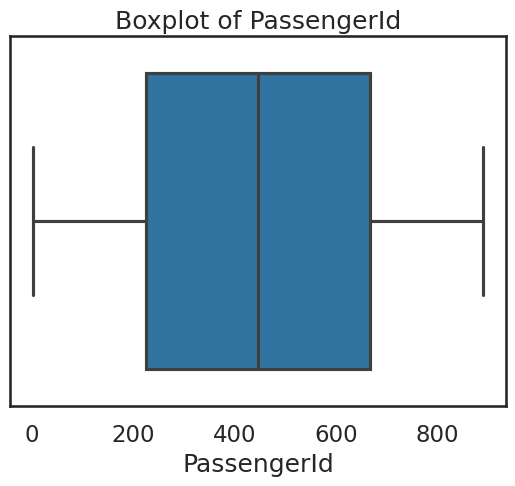

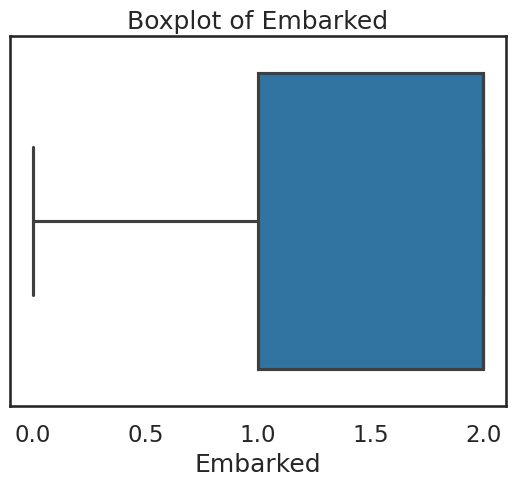

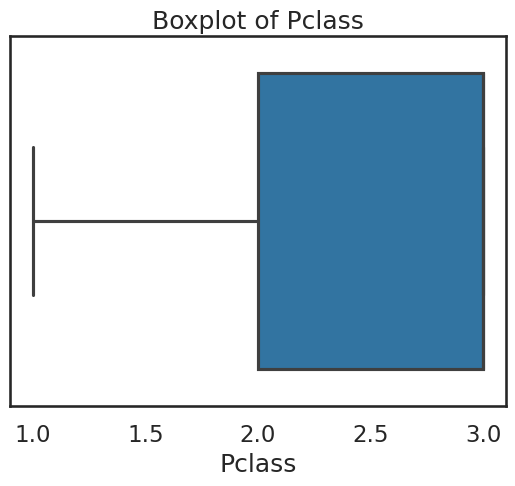

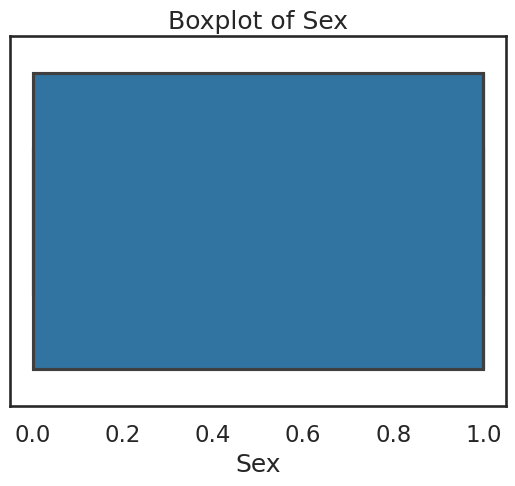

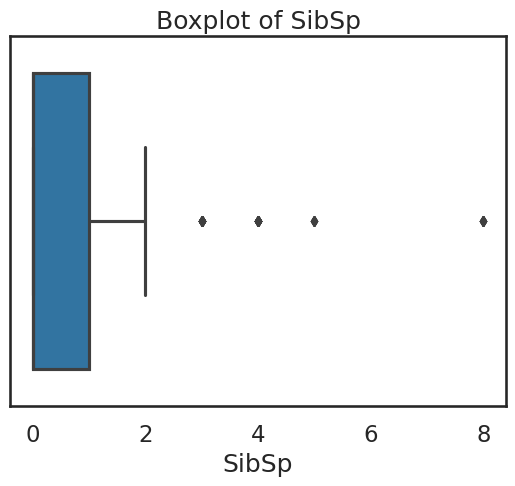

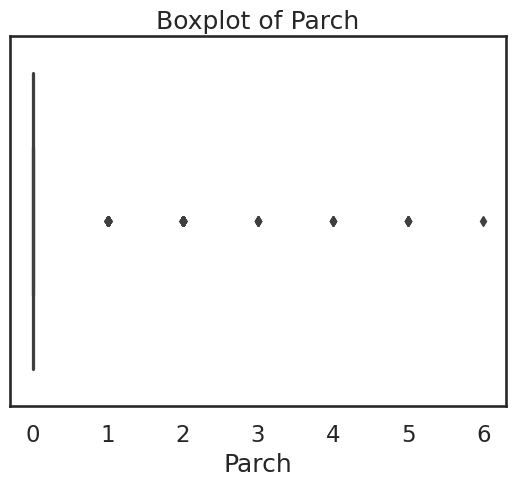

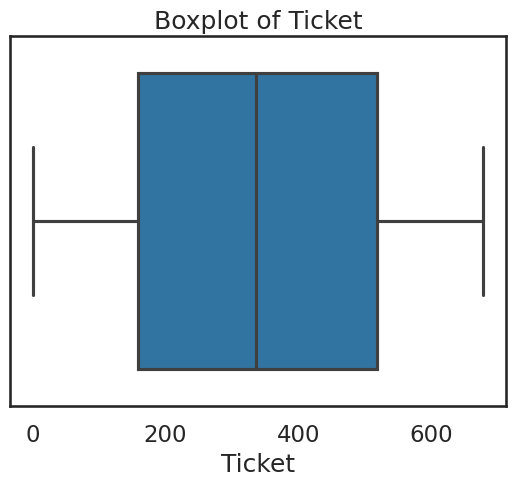

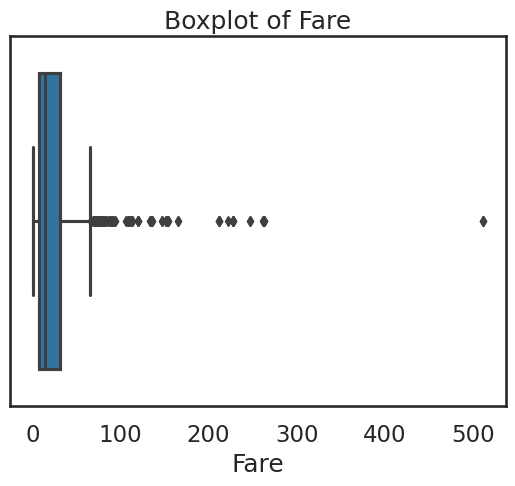

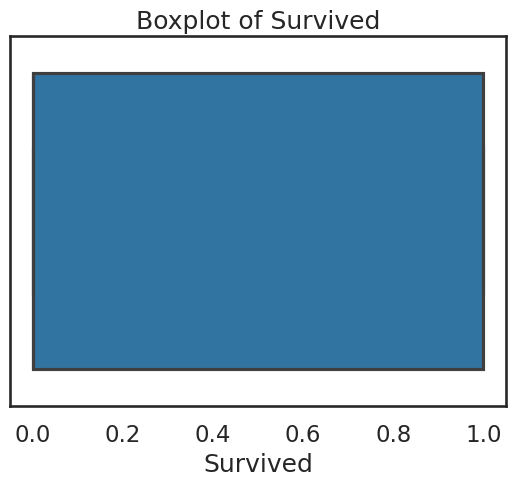

In [671]:
for column in titanic_data.columns:
  plt.figure()


  sns.boxplot(x=titanic_data[column])
  plt.title(f'Boxplot of {column}')
  plt.show()



In [672]:
#There are some outliers in SibSp and Fare, let's remove them from our data
SibSp_Indexes = list(titanic_data[titanic_data['SibSp'] > 7].index)
Fare_Indexes = list(titanic_data[titanic_data['Fare'] > 400].index)
All_Indexes_To_Be_Removed = SibSp_Indexes+Fare_Indexes
len(All_Indexes_To_Be_Removed)

10

In [673]:
titanic_data = titanic_data.drop(index=All_Indexes_To_Be_Removed)


# Now let's separate our training and test data with a split

In [674]:
X = titanic_data.drop("Survived",axis=1)
y = titanic_data["Survived"]
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.3, random_state=1)

#Let's scale the data as it is required in some models

In [675]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

# Now our datase is ready to be learned by the models

# **Logistic Regression**
This is the simplest model and will probably not result in good accuracy, but let us give it a try

In [676]:
##Linear Regression
LogisticModel = LogisticRegression(solver='liblinear')
LogisticModel.fit(X_train,y_train)
PredictionsLogisticModel = LogisticModel.predict(X_test)
LogisticModel.score(X_test,y_test)


0.7992424242424242

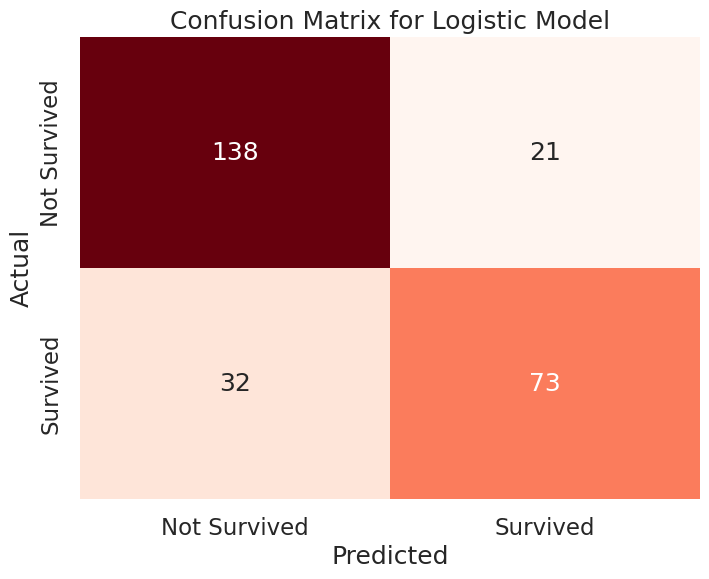

In [677]:
Built_Conf_Matrix(y_test,PredictionsLogisticModel,"Logistic Model")

# We got around 80% of accuracy
# Now let's use cross-validation with L1 and L2 penalties

In [678]:
LogisticModel_l1 = LogisticRegressionCV(penalty='l1', solver='liblinear').fit(X_train, y_train)
PredictionsLogisticModel_l1 = LogisticModel_l1.predict(X_test)
LogisticModel_l1.score(X_test,y_test)


0.803030303030303

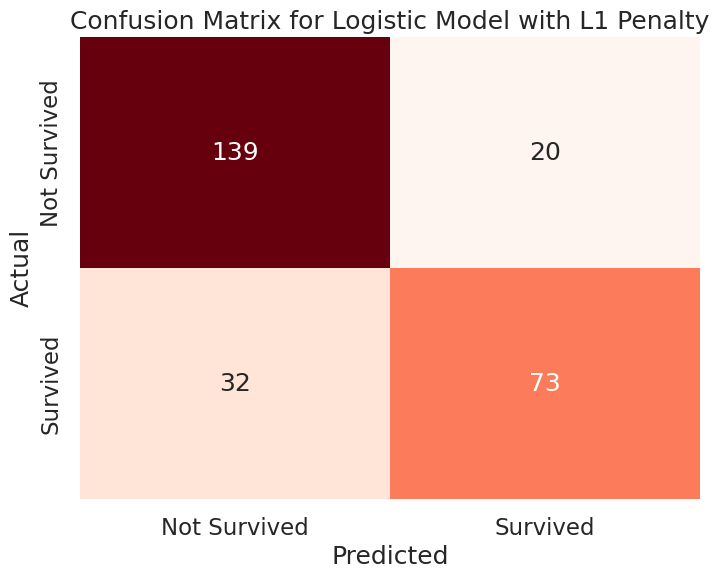

In [679]:
Built_Conf_Matrix(y_test,PredictionsLogisticModel_l1,"Logistic Model with L1 Penalty")

In [680]:
LogisticModel_l2 = LogisticRegressionCV(penalty='l2', solver='liblinear').fit(X_train, y_train)
PredictionsLogisticModel_l2 = LogisticModel_l2.predict(X_test)
LogisticModel_l2.score(X_test,y_test)

0.7992424242424242

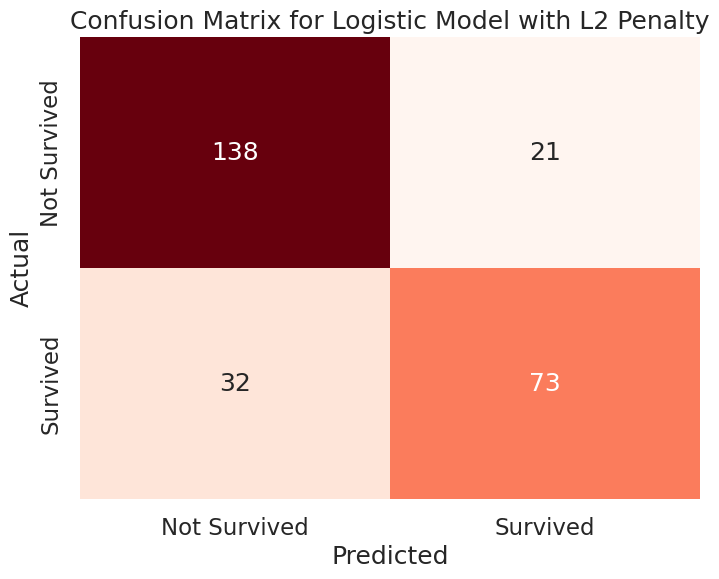

In [681]:
Built_Conf_Matrix(y_test,PredictionsLogisticModel_l2,"Logistic Model with L2 Penalty")

# Logistic Regression Results:
The use of cross-validation with L1 or L2 penalties barely made a difference in comparison to the raw Logistic Regression model. We got around 80% of accuracy with the Logistic Regression models

# **KNN**

# Let's find the best number of neighbors from 2 to 50, the highest the accuracy we get in our testing data, the better the model is

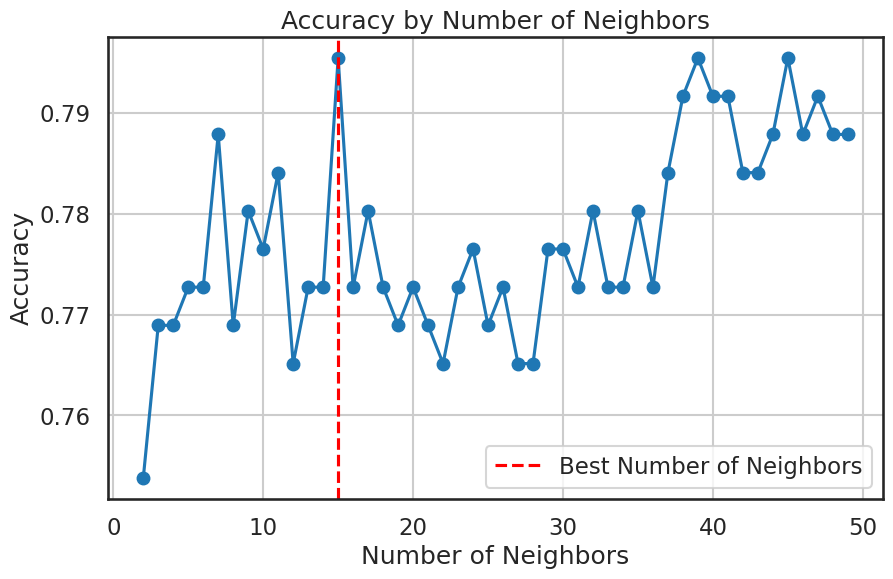

Best accuracy out of KNN: 0.7954545454545454


In [682]:
Accuracy_List_Knn = []

# Preciision, recall, f-score from the multi-class support function
for x in range(2,50):
  KnnModel = KNeighborsClassifier(n_neighbors=x)
  KnnModel = KnnModel.fit(X_train, y_train)
  PredictionsKnnModel = KnnModel.predict(X_test)
  #print(classification_report(y_test, PredictionsKnnModel))
  Accuracy_List_Knn.append(accuracy_score(y_test, PredictionsKnnModel))
  #print('Accuracy score: ',)
  #print('F1 Score: ', round(f1_score(y_test, PredictionsKnnModel), 2))

Best_Number_Neighbor = Accuracy_List_Knn.index(max(Accuracy_List_Knn))
plt.figure(figsize=(10, 6))
plt.plot(range(2, 50), Accuracy_List_Knn, marker='o')
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.title('Accuracy by Number of Neighbors')
plt.axvline(x=Best_Number_Neighbor+2, color='r', linestyle='--', label='Best Number of Neighbors')
plt.legend()
plt.grid(True)
plt.show()
print("Best accuracy out of KNN: " + str(Accuracy_List_Knn[Best_Number_Neighbor]))

In [683]:
Best_KnnModel = KNeighborsClassifier(n_neighbors=Best_Number_Neighbor)
Best_KnnModel = Best_KnnModel.fit(X_train, y_train)
PredictionsBestKnnModel = Best_KnnModel.predict(X_test)

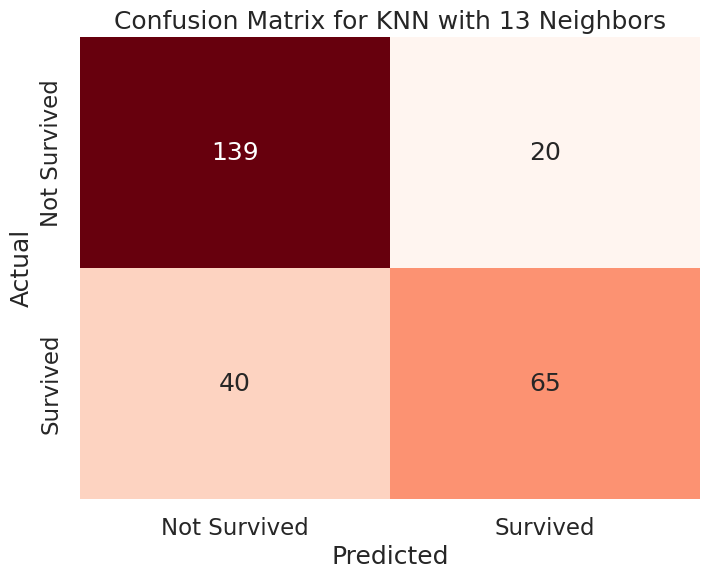

In [684]:
Built_Conf_Matrix(y_test,PredictionsBestKnnModel,"KNN with " + str(Best_Number_Neighbor) + " Neighbors")

# Results of KNN:
 We got around 80% of accuracy with KNN, seeing 48 different neighbor values and getting the best score with 13 neighbors.

# **Default SVC**


In [685]:
SVCModel = SVC()
SVCModel.fit(X_train, y_train)
SVCModelPredictions = SVCModel.predict(X_test)
accuracy_score(y_test,SVCModelPredictions)

0.7916666666666666

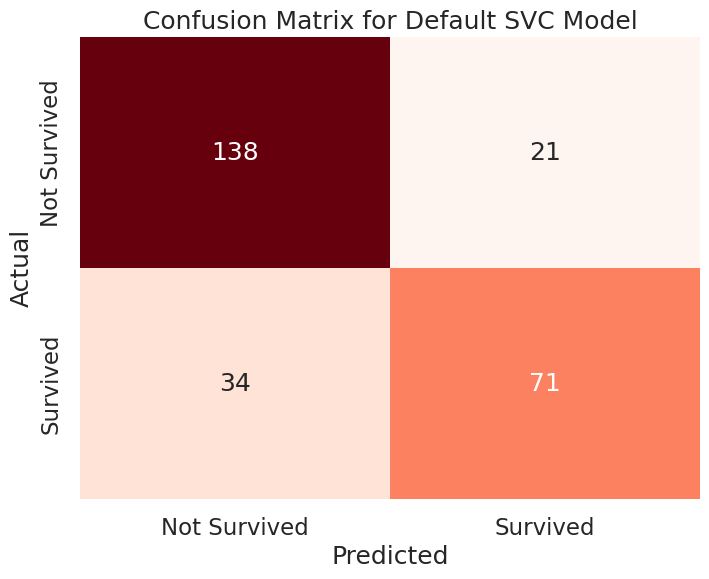

In [686]:
Built_Conf_Matrix(y_test,SVCModelPredictions,"Default SVC Model")

# We see that we get an accuracy of around 79%

# Let's try to add a sigmoid kernel, considering our output(Survival) is binary

In [687]:
SVCSigmoidList = []
for x in range(1,100):
    SVCSigmoidModel = SVC(C=x, kernel='sigmoid')
    SVCSigmoidModel.fit(X_train, y_train)
    SVCSigmoidPredictions = SVCSigmoidModel.predict(X_test)
    SVCSigmoidList.append(accuracy_score(y_test, SVCSigmoidPredictions))

BestSVCSigmoidModel = SVC(C=SVCSigmoidList.index(max(SVCSigmoidList)), kernel='sigmoid')
BestSVCSigmoidModel = BestSVCSigmoidModel.fit(X_train,y_train)
BestSVCSigmoidModelPredictions = BestSVCSigmoidModel.predict(X_test)
max(SVCSigmoidList),SVCSigmoidList.index(max(SVCSigmoidList))

(0.75, 50)

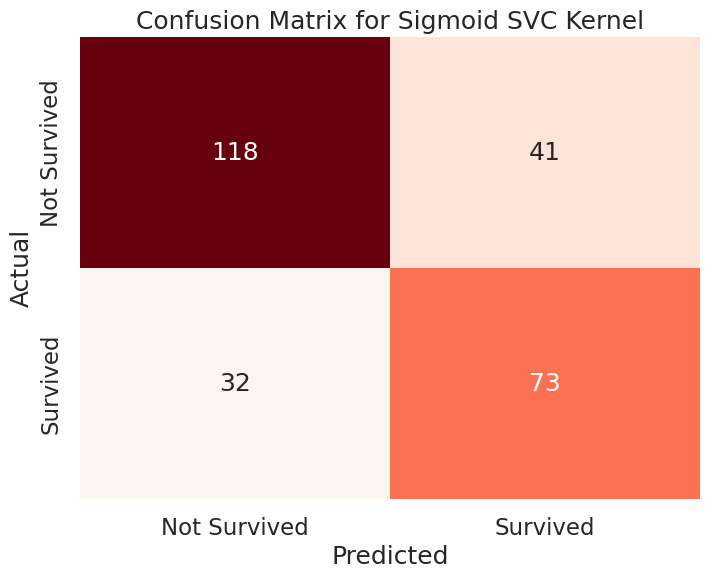

In [688]:
Built_Conf_Matrix(y_test,BestSVCSigmoidModelPredictions,"Sigmoid SVC Kernel")

# We got a 75% accuracy with the sigmoid kernel with a C value of 50

# Now let's try a linear SVC Model

In [689]:
LinearSVCModel = LinearSVC()
LinearSVCModel.fit(X_train, y_train)
LinearSVCModelPredictions = LinearSVCModel.predict(X_test)
LinearSVCModel.score(X_test,y_test)

0.7840909090909091

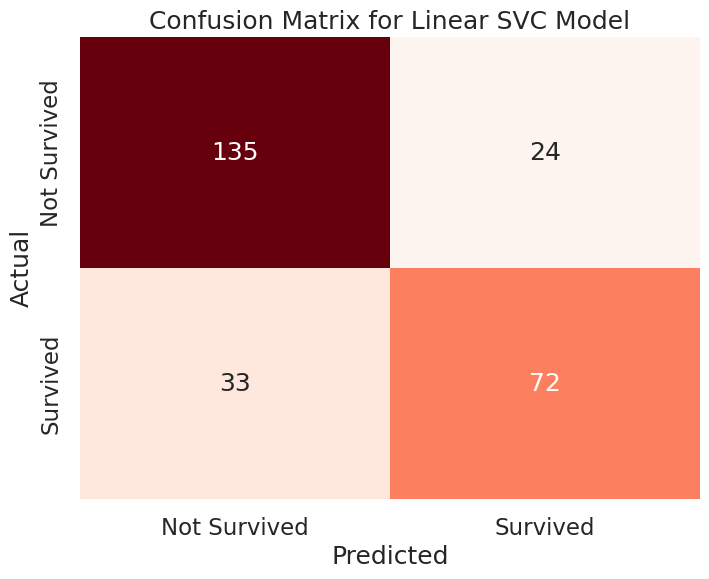

In [690]:
Built_Conf_Matrix(y_test,LinearSVCModelPredictions,"Linear SVC Model")

# We got a 78% accuracy with the linear SVC Model

# A Gaussian SVC might suit us better

# We can find the best SVC accuracy changing the gamma values

In [691]:
SVC_Accuracy_List = []
for x in range(0,1000,10):
    SVCGaussianModel= SVC(kernel='rbf', gamma=x/100)
    SVCGaussianModel.fit(X_train,y_train)
    SVC_Accuracy_List.append(SVCGaussianModel.score(X_test,y_test))

BestSVCGaussianAccuracy= max(SVC_Accuracy_List)
BestSVCGaussianModel = SVC(kernel='rbf', gamma= max(SVC_Accuracy_List)/100)
BestSVCGaussianModel = BestSVCGaussianModel.fit(X_train,y_train)
BestSVCGaussianModelPredictions= BestSVCGaussianModel.predict(X_test)
print("The best accuracy using SVC with the Gaussian Model was " + str(BestSVCGaussianAccuracy) + " with a gamma value of " + str((SVC_Accuracy_List.index(BestSVCGaussianAccuracy) * 100) / 10))

The best accuracy using SVC with the Gaussian Model was 0.7954545454545454 with a gamma value of 20.0


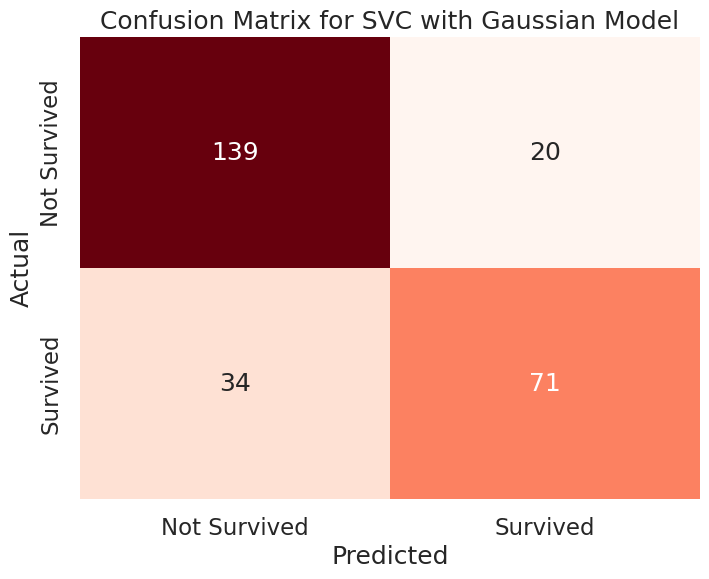

In [692]:
Built_Conf_Matrix(y_test,BestSVCGaussianModelPredictions,"SVC with Gaussian Model")

# The accuracy  was a little more better than the one from the simple Linear SVC, around 80%

# **Results of SVC**:
We got around 80% accuracy using the Gaussian SVC Model.

# **Decision Tree**

In [693]:
DecisionTreeModel = DecisionTreeClassifier(random_state=1)
DecisionTreeModel = DecisionTreeModel.fit(X_train, y_train)

In [694]:
DecisionTreeModelPredictions = DecisionTreeModel.predict(X_test)


In [695]:
accuracy_score(y_test,DecisionTreeModelPredictions)

0.7765151515151515

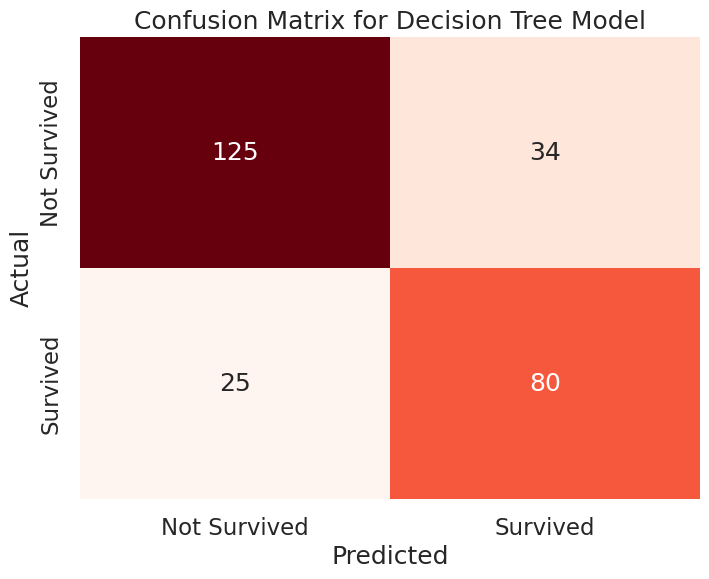

In [696]:
Built_Conf_Matrix(y_test,DecisionTreeModelPredictions,"Decision Tree Model")

# We got around 78% of accuracy using the simple Decision Tree. We can try a different approach by trying to find the best paramethers using a GridSearch Cross-validation.

In [697]:
param_grid = {'max_depth':range(1, DecisionTreeModel.tree_.max_depth+1),
              'max_features': range(1, len(DecisionTreeModel.feature_importances_)+1),
              'criterion': ['gini', 'entropy'],
}

BestDecisionTreeModel = GridSearchCV(DecisionTreeClassifier(random_state=42),
                     param_grid=param_grid,
                     scoring='accuracy',
                      n_jobs=-1)
BestDecisionTreeModel = BestDecisionTreeModel.fit(X_train,y_train)

In [698]:
BestDecisionTreeModel.best_estimator_.tree_.node_count, BestDecisionTreeModel.best_estimator_.tree_.max_depth

(15, 3)

In [699]:
BestDecisionTreeModelPredictions = BestDecisionTreeModel.predict(X_test)
accuracy_score(BestDecisionTreeModelPredictions,y_test)

0.8106060606060606

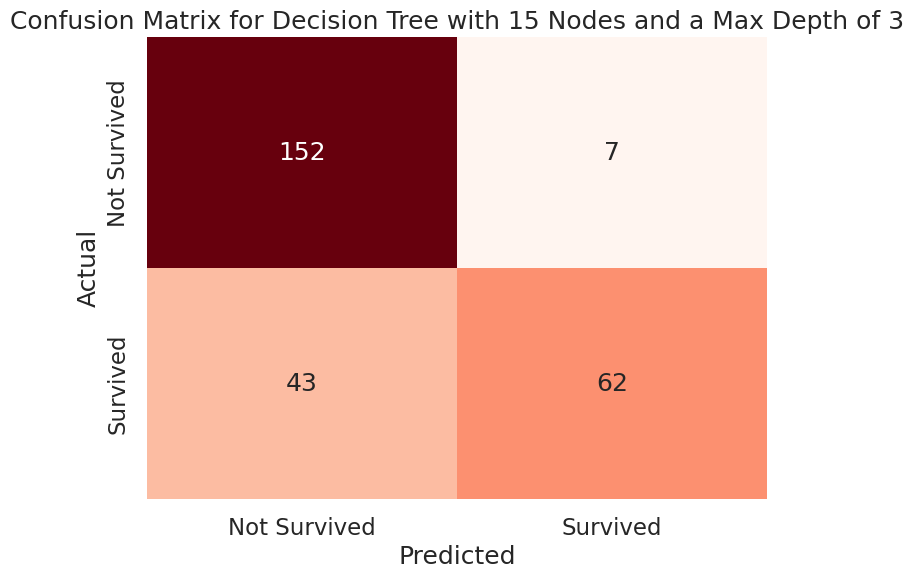

In [700]:
Built_Conf_Matrix(y_test,BestDecisionTreeModelPredictions,"Decision Tree with 15 Nodes and a Max Depth of 3")

# We got around 81% of accuracy using the Decision Tree Model with 15 nodes and 3 of maximum depth



# **Results of Decision Tree**

We got around 81% of accuracy, using a Decision Tree with 15 nodes and a maximum depth of 3.

# **Random Forest**:
Now let's try using a Random Forest model to predict the data, we will use a different set of trees(10 to 1000 adding 10 in each loop, ex: 10,20,30,40,...980,990,1000)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


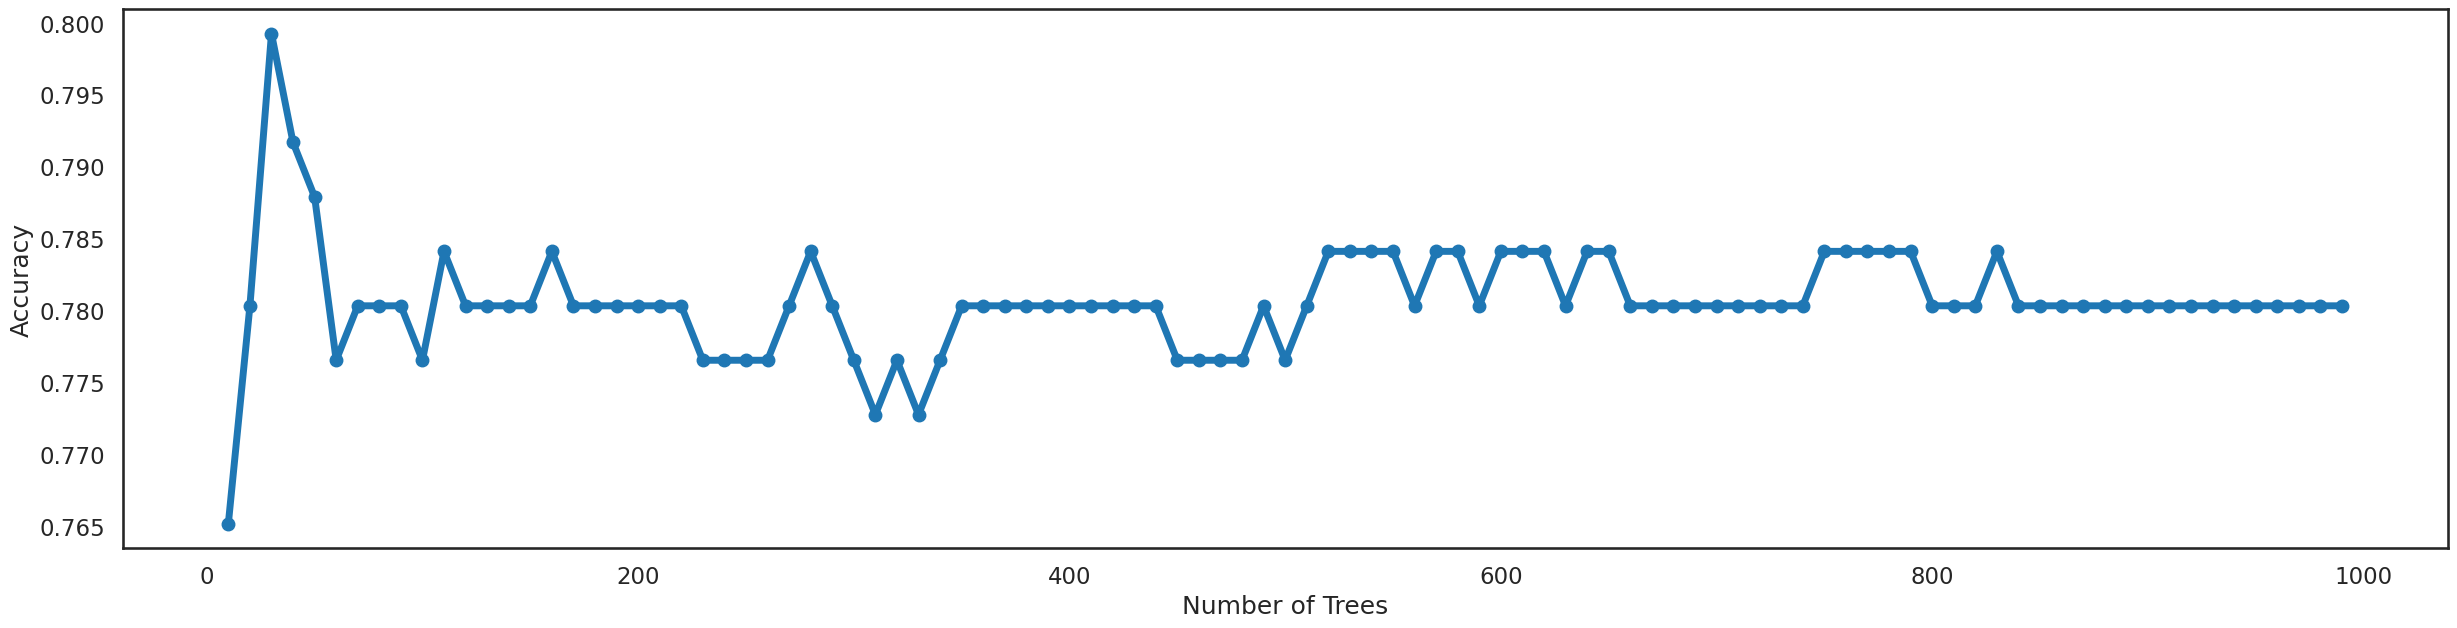

In [701]:
RandomForestModel= RandomForestClassifier(oob_score=True,
                            random_state=1,
                            warm_start=True,
                            n_jobs=-1)

acc_list_rf = list()

# Iterate through all of the possibilities for
# number of trees
for n_trees in [x for x in range(10,1000,10)]:
    RandomForestModel.set_params(n_estimators=n_trees)
    RandomForestModel.fit(X_train, y_train)
    RandomForestPredictions = RandomForestModel.predict(X_test)
    accuracy_rf = accuracy_score(y_test,RandomForestPredictions)
    acc_list_rf.append(pd.Series({'Number of Trees': n_trees, 'Accuracy': accuracy_rf}))

rf_acc_df = pd.concat(acc_list_rf, axis=1).T.set_index('Number of Trees')

sns.set_context('talk')
sns.set_style('white')
ax = rf_acc_df.plot(legend=False, marker='o', figsize=(30, 7), linewidth=5)
ax.set(ylabel='Accuracy');

In [702]:
df = pd.DataFrame(acc_list_rf)
highest_accuracy_row = df.loc[df['Accuracy'].idxmax()]
highest_accuracy = highest_accuracy_row['Accuracy']
number_of_trees = highest_accuracy_row['Number of Trees']
BestRandomForestModel = RandomForestClassifier(oob_score=True,
                                               n_estimators=    int(highest_accuracy_row['Number of Trees']),
                            random_state=1,
                            warm_start=True,
                            n_jobs=-1)
BestRandomForestModel = BestRandomForestModel.fit(X_train,y_train)
BestRandomForestModelPredictions = BestRandomForestModel.predict(X_test)
print("Highest Accuracy:", highest_accuracy)
print("Number of Trees:", number_of_trees)

Highest Accuracy: 0.7992424242424242
Number of Trees: 30.0


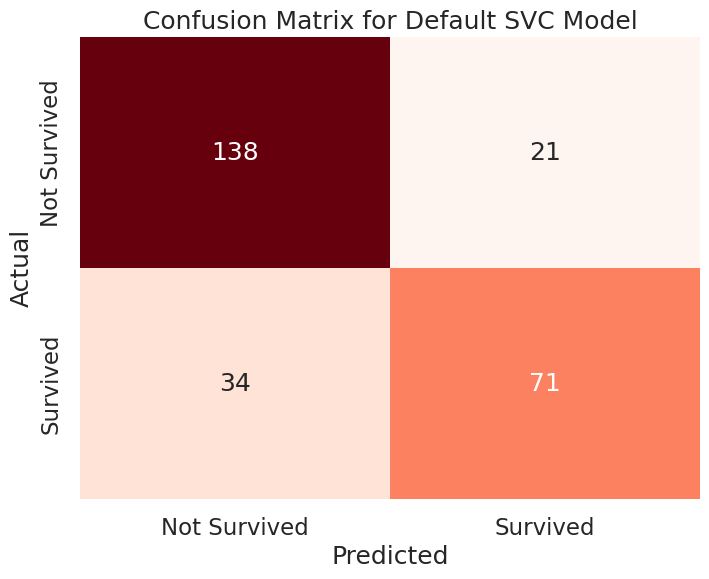

In [703]:
Built_Conf_Matrix(y_test,SVCModelPredictions,"Default SVC Model")

# We got around 80% of accuracy with 31 trees using Random Trees

# **Extra Trees**:
We will use the same code as we did with Random Forest, with the same number of trees, except it will be an extra tree model, it could be useful considering it trains itself on the entire dataset, meaning it could learn more effectivally than random trees



/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


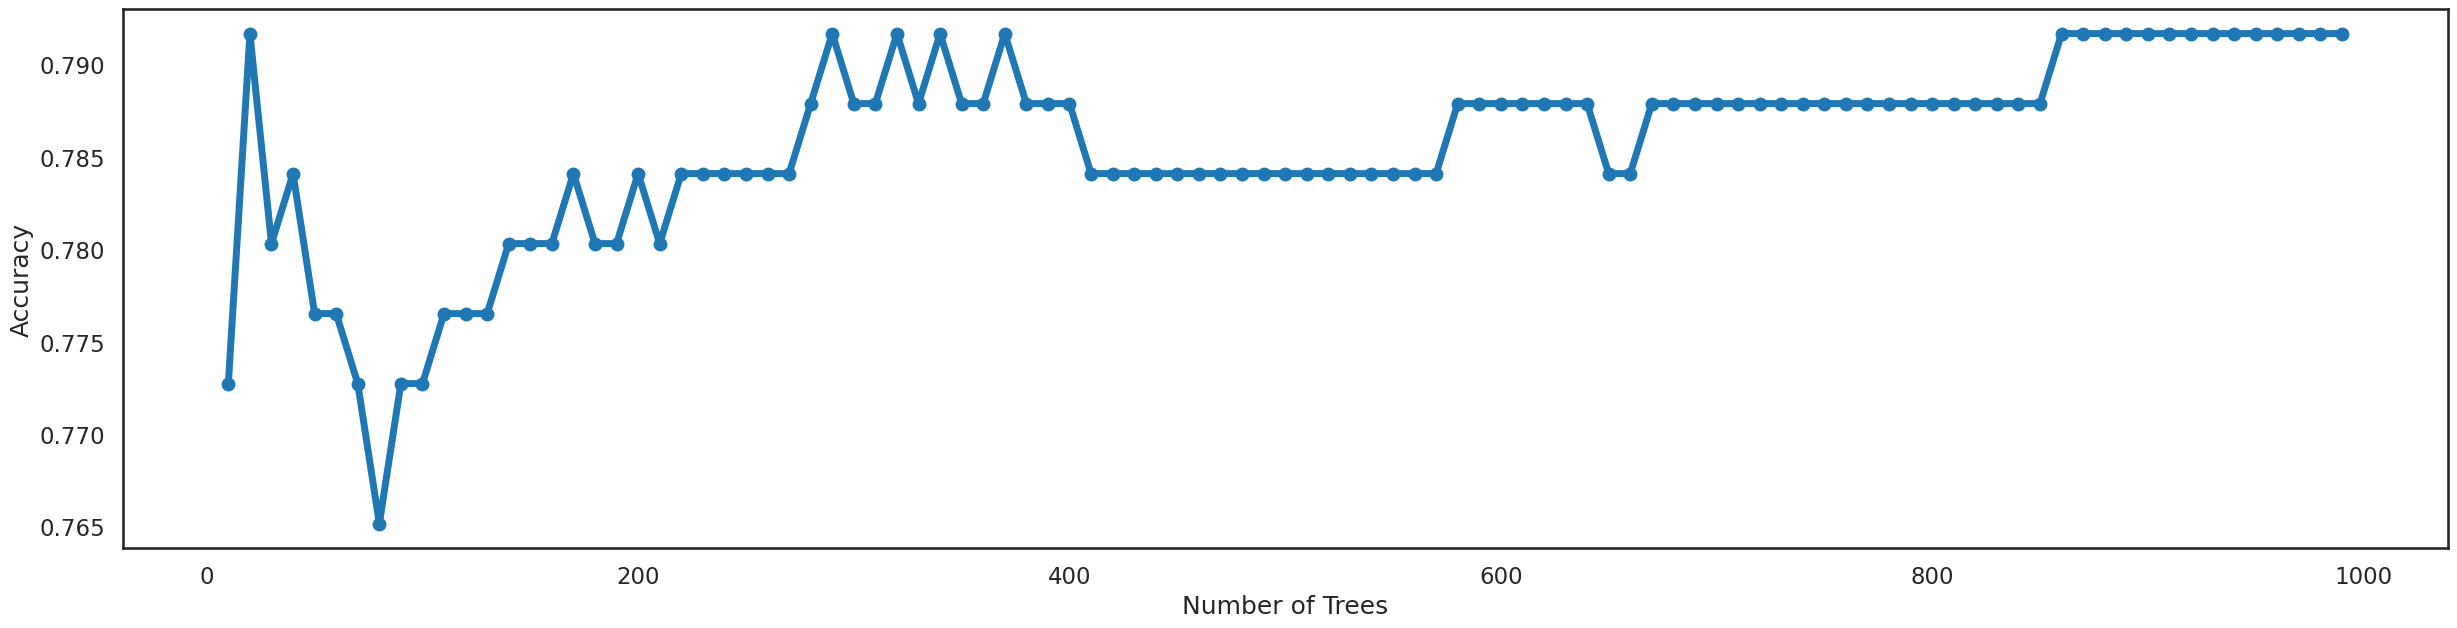

In [704]:
ExtraTreeModel= ExtraTreesClassifier(oob_score=True,
                            random_state=1,
                            warm_start=True,
                            bootstrap=True,
                            n_jobs=-1)

acc_list_et = list()

# Iterate through all of the possibilities for
# number of trees
for n_trees in [x for x in range(10,1000,10)]:
    ExtraTreeModel.set_params(n_estimators=n_trees)
    ExtraTreeModel.fit(X_train, y_train)
    ExtraTreePredictions = ExtraTreeModel.predict(X_test)
    accuracy_et = accuracy_score(y_test,ExtraTreePredictions)
    acc_list_et.append(pd.Series({'Number of Trees': n_trees, 'Accuracy': accuracy_et}))

et_acc_df = pd.concat(acc_list_et, axis=1).T.set_index('Number of Trees')

sns.set_context('talk')
sns.set_style('white')
ax = et_acc_df.plot(legend=False, marker='o', figsize=(30, 7), linewidth=5)
ax.set(ylabel='Accuracy');

In [705]:
df = pd.DataFrame(acc_list_et)
highest_accuracy_row = df.loc[df['Accuracy'].idxmax()]
highest_accuracy = highest_accuracy_row['Accuracy']
number_of_trees = highest_accuracy_row['Number of Trees']
print("Highest Accuracy:", highest_accuracy)
print("Number of Trees:", number_of_trees)

Highest Accuracy: 0.7916666666666666
Number of Trees: 20.0


In [706]:
BestExtraTreeModel= ExtraTreesClassifier(oob_score=True,
                            random_state=1,
                            warm_start=True,
                            bootstrap=True,
                            n_estimators=41,
                            n_jobs=-1)
BestExtraTreeModel = BestExtraTreeModel.fit(X_train,y_train)
PredictionsBestExtraTreeModel = BestExtraTreeModel.predict(X_test)


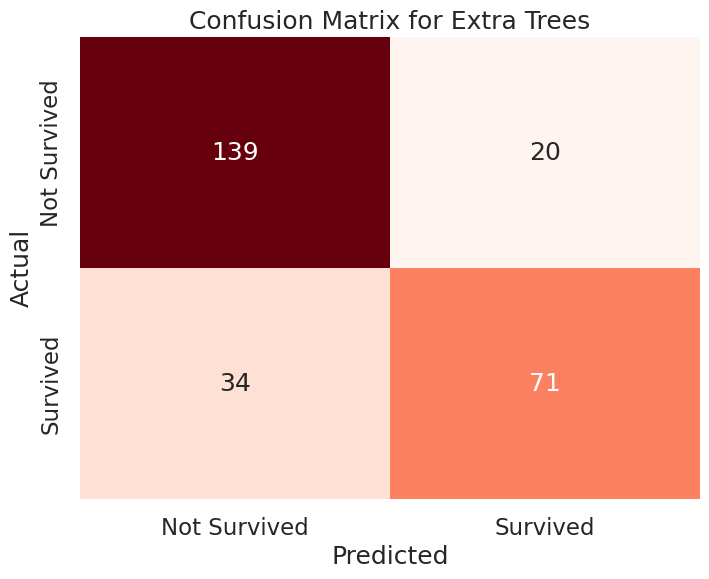

In [707]:
Built_Conf_Matrix(y_test,PredictionsBestExtraTreeModel,"Extra Trees")

# **Results of Extra Trees**:
We got almost 80% of accuracy with 41 trees using Extra Trees, not higher than the accuracy we got from using Random Forest, meaning that the model didn't benefit much using all the data for training.

# **General Results**:
We can see that the best result we've gotten is from the Decision Tree with 15 nodes and a maximum depth of 3, with around 81% of accuracy

# **What's Next?**
There are many reasons as to why our data wasn't properly learned by all of these models, maybe the data simply didn't have much patterns to be learned considering it isn't simple to determine whether a person will die or not, or maybe our models lacked the complexity to actually learn the data.
But there's probably a simpler explanation, imbalanced classes.


# Let's confirm this theory by analysing the ammount of people who survived vs the people who did not in our training data

<BarContainer object of 2 artists>

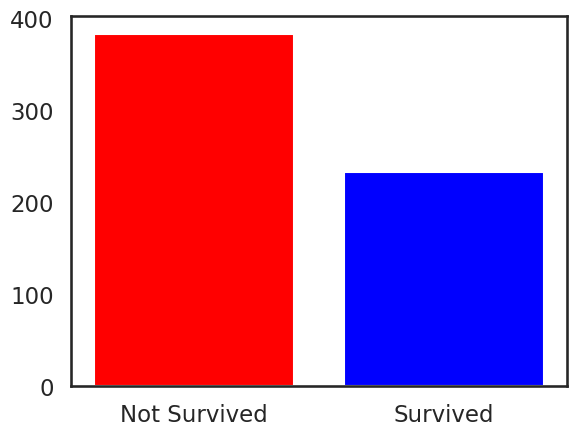

In [708]:
count_deaths = (y_train == 0).sum()
count_survivors = (y_train == 1).sum()
plt.bar([0,1], [count_deaths,count_survivors], tick_label=['Not Survived', 'Survived'], color=['red', 'blue'])

As we can see the classes are indeed umbalanced, with more deaths than survivors, there are many ways to fix this problem, we can choose to split the data in a different way, using ShuffleSplit, another percentage of test_split or even another random_state value.
But in this problem I will use Synthetic Minority Oversampling Technique (SMOTE) to see if it will benefit us in any way.

In [709]:
SmoteSampler = SMOTE(random_state = 1)
X_smote, y_smote = SmoteSampler.fit_resample(X_train, y_train)

<BarContainer object of 2 artists>

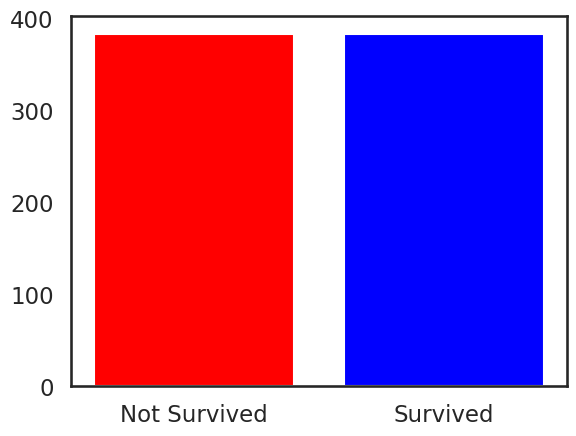

In [710]:
count_deaths = (y_smote == 0).sum()
count_survivors = (y_smote == 1).sum()
plt.bar([0,1], [count_deaths,count_survivors], tick_label=['Not Survived', 'Survived'], color=['red', 'blue'])

# Now that our classes are perfectly balanced, let's try to train our best Decision Tree again with them

In [711]:
BestDecisionTreeModel = GridSearchCV(DecisionTreeClassifier(random_state=42),
                     param_grid=param_grid,
                     scoring='accuracy',
                      n_jobs=-1)
BestDecisionTreeModel = BestDecisionTreeModel.fit(X_smote,y_smote)



In [712]:
BestDecisionTreeModelPredictions = BestDecisionTreeModel.predict(X_test)
accuracy_score(BestDecisionTreeModelPredictions,y_test)

0.7765151515151515

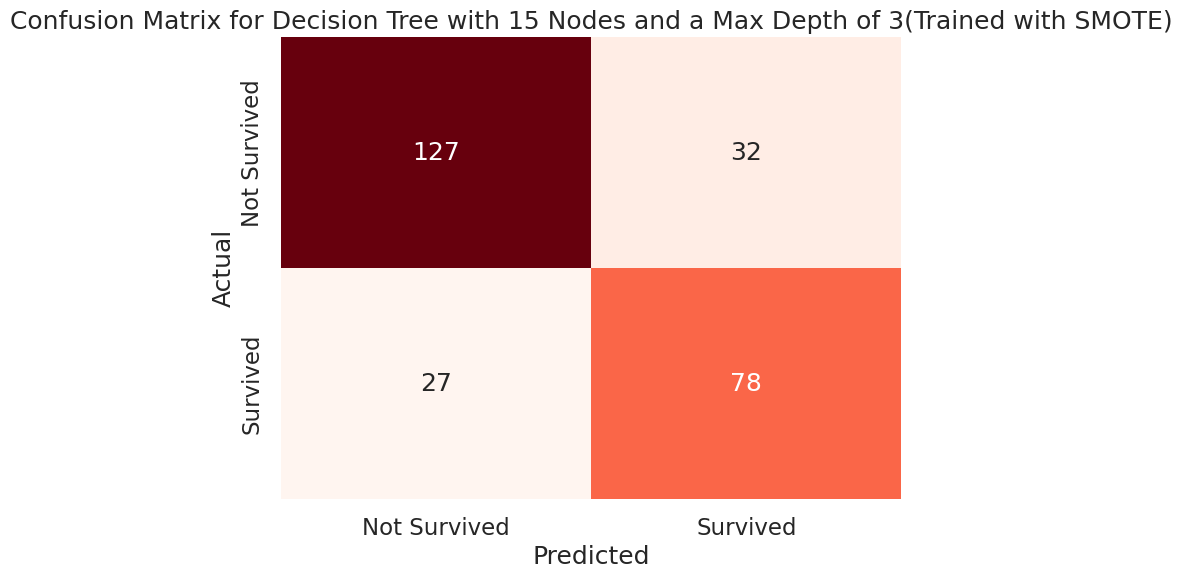

In [713]:
Built_Conf_Matrix(y_test,BestDecisionTreeModelPredictions,"Decision Tree with 15 Nodes and a Max Depth of 3(Trained with SMOTE)")


# It did not result in a good accuracy, so let's combine SMOTE with ShuffleSplit

In [714]:
stratified_split = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=1)
X = titanic_data[titanic_data.columns[:-1]]
y = titanic_data['Survived']
X_array = X.values
y_array = y.values
train_idx, test_idx = next(stratified_split.split(X_array, y_array))
X_train = X_array[train_idx]
y_train = y_array[train_idx]
X_test = X_array[test_idx]
y_test = y_array[test_idx]
SmoteSampler = SMOTE(random_state = 1)
X_smote, y_smote = SmoteSampler.fit_resample(X_train, y_train)


In [715]:
BestDecisionTreeModel = BestDecisionTreeModel.fit(X_smote,y_smote)
BestDecisionTreeModelPredictions = BestDecisionTreeModel.predict(X_test)
accuracy_score(BestDecisionTreeModelPredictions,y_test)

0.8143939393939394

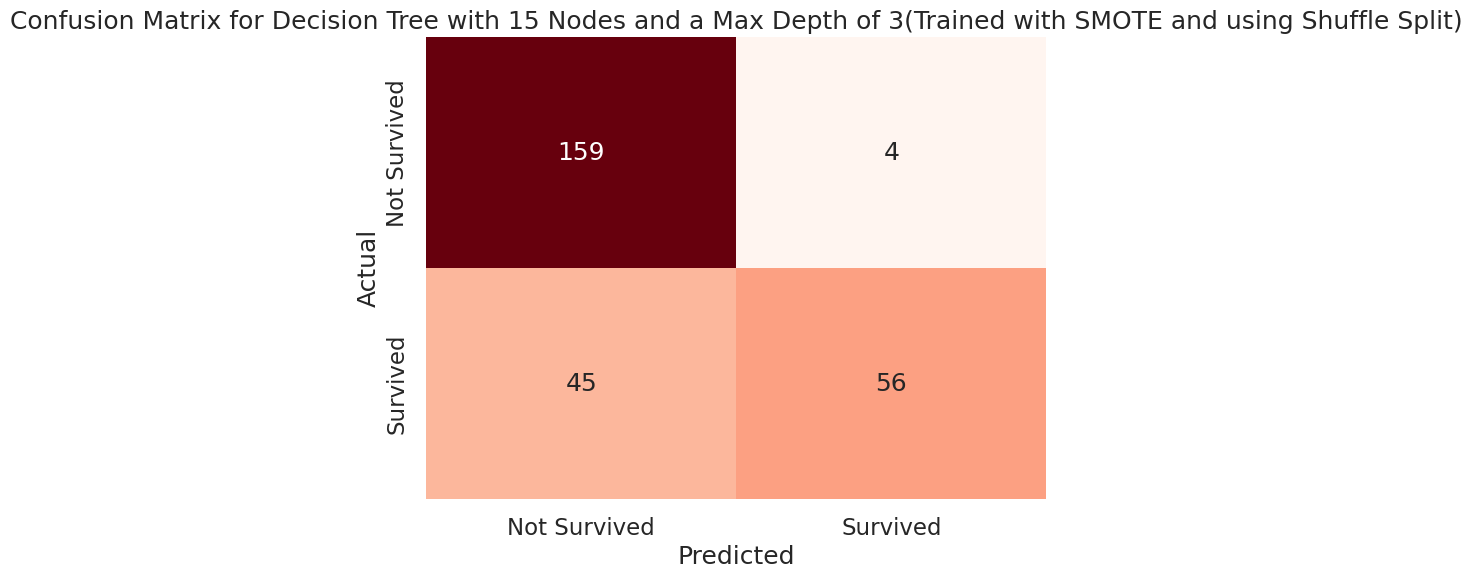

In [716]:
Built_Conf_Matrix(y_test,BestDecisionTreeModelPredictions,"Decision Tree with 15 Nodes and a Max Depth of 3(Trained with SMOTE and using Shuffle Split)")

# **Conclusions**:
We saw that SMOTE did actually benefit the learning of the data when we used a Shuffle Split, with a prediction of more than 81%

# **Next Steps**:


*   Try different variations of the previous models seen: see if, for example, an even higher number of trees or neighbors benefits the learning of the data
*   Try to fill the null values instead of removing them: if you use correlation, for example, you could fill most of the null Cabin values with the values of similar "neighbors".
*   Use ShuffleSplit instead of the regular training split: it could help our model learn our data in a more efficient way.
* Use SMOTE with the data and see if the accuracy of the models vary: it could be benefitial and lead to better accuracies.

